In [1]:
# Définir les répertoires source des vidéos réelles et fausses
source_dir_real = '/kaggle/input/celeb-df-v2/Celeb-real'
source_dir_fake = '/kaggle/input/celeb-df-v2/Celeb-synthesis'
# Définir les répertoires de destination pour les vidéos réelles et fausses
destination_dir_real = '/kaggle/working/dataset/Real'
destination_dir_fake = '/kaggle/working/dataset/Fake'
# Définir le répertoire racine du dataset
dataset_root = '/kaggle/working/dataset'

In [2]:
# Notre Fonction d'extraction
def extract_video_frames(video_paths, image_size=(64, 64), num_frames=500):
    processed_videos = []

    # Parcourir tous les chemins de vidéo
    for video_path in video_paths:
        video_capture = cv2.VideoCapture(video_path)
        frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

        # Vérifier si la vidéo est corrompue ou vide
        if frame_count <= 0:
            print(f"Skipping corrupted or empty video: {video_path}")
            processed_videos.append(np.zeros((num_frames, image_size[0], image_size[1], 3), dtype=np.float32))
            continue

        # Calculer les indices des frames à extraire
        frame_indices = (
            np.linspace(0, frame_count - 1, num_frames, dtype=int) 
            if frame_count >= num_frames 
            else np.concatenate([np.arange(frame_count), np.random.choice(np.arange(frame_count), num_frames - frame_count)])
        )
        
        frames = []
        for frame_idx in frame_indices:
            video_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = video_capture.read()
            if not ret:
                frames.append(np.zeros((image_size[0], image_size[1], 3), dtype=np.uint8))
                continue
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            frame = cv2.resize(frame, image_size)  # Resize to desired size
            frames.append(frame)

        video_capture.release()

        # Normaliser les frames
        frames = np.array(frames) / 255.0
        processed_videos.append(frames)

    return np.array(processed_videos)


In [3]:
import os
import shutil

# Créer les répertoires de destination 
os.makedirs(destination_dir_real, exist_ok=True)
os.makedirs(destination_dir_fake, exist_ok=True)

# Lister les fichiers du répertoire source réel
file_list_real = os.listdir(source_dir_real)

# Copier les 100 premiers fichiers du répertoire source réel vers le répertoire de destination réel
for filename in file_list_real[:100]:
    source_file = os.path.join(source_dir_real, filename)
    destination_file = os.path.join(destination_dir_real, filename)
    shutil.copy(source_file, destination_file)
    
# Lister les fichiers du répertoire source fake
file_list_fake = os.listdir(source_dir_fake)

# Copier les 100 premiers fichiers du répertoire source fake vers le répertoire de destination fake
for filename in file_list_fake[:100]:
    source_file = os.path.join(source_dir_fake, filename)
    destination_file = os.path.join(destination_dir_fake, filename)
    shutil.copy(source_file, destination_file)

# Message de confirmation
print("Files copied successfully.")

Files copied successfully.


In [4]:
iimport os
import random
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
import cv2

In [6]:
# Sélectionner 300 vidéos fausses au hasard
random.seed(42) # Fixer la seed pour la reproductibilité
selected_fake_videos = random.sample(file_list_fake,300) # Sélectionner 300 vidéos fausses

# Suréchantillonner les vidéos réelles pour correspondre à la taille du dataset des vidéos fausses
real_videos = file_list_real[:300]   # Limiter à exactement 300 vidéos réelles

# Combiner les chemins des vidéos réelles et fausses
balanced_real_paths = [os.path.join(source_dir_real, video) for video in real_videos]
balanced_fake_paths = [os.path.join(source_dir_fake, video) for video in selected_fake_videos]

# Créer la liste complète des chemins de vidéo
video_paths = balanced_real_paths + balanced_fake_paths
# Créer les labels (0 pour réel, 1 pour faux)
labels = np.concatenate([np.zeros(len(balanced_real_paths)), np.ones(len(balanced_fake_paths))])  # 0 pour reel, 1 poor fake

# Traiter les vidéos et extraire les frames
image_size = (64, 64)  
num_frames = 20       

# Diviser la liste des fichiers en ensembles d'entraînement et de validation
video_paths_train, video_paths_test, y_train, y_test = train_test_split(
    video_paths, labels, test_size=0.2, random_state=42
)
# Extraire les frames pour l'entraînement et le test
X_videos_train = extract_video_frames(video_paths_train, image_size, num_frames)
X_videos_test = extract_video_frames(video_paths_test, image_size, num_frames)

# Afficher les dimensions des jeux de données
print("X_videos_train shape:", X_videos_train.shape)
print("X_videos_test shape:", X_videos_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_videos_train shape: (480, 20, 64, 64, 3)
X_videos_test shape: (120, 20, 64, 64, 3)
y_train shape: (480,)
y_test shape: (120,)


In [7]:
# Aplatir les frames extraites pour les vidéos réelles et fausses
X_videos_real_flattened = X_videos_train[np.where(y_train == 0)]
X_videos_fake_flattened = X_videos_train[np.where(y_train == 1)]

# Combiner les frames en un seul jeu de données
X_images_real_flattened = X_videos_real_flattened.reshape(-1, 64, 64, 3)
X_images_fake_flattened = X_videos_fake_flattened.reshape(-1, 64, 64, 3)

# Créer les labels correspondants
y_real_flattened = np.zeros(X_images_real_flattened.shape[0])  # Label 0 pour reel
y_fake_flattened = np.ones(X_images_fake_flattened.shape[0])  # Label 1 for fake

# Combine real and fake images and their labels
X_images = np.concatenate((X_images_real_flattened, X_images_fake_flattened), axis=0)
y = np.concatenate((y_real_flattened, y_fake_flattened), axis=0)

# Mélanger et diviser en ensembles d'entraînement et de test
X_images_train, X_images_test, y_train, y_test = train_test_split(
    X_images, y, test_size=0.2, random_state=42
)

# Afficher les dimensions des jeux de données
print("X_images_train shape:", X_images_train.shape)
print("X_images_test shape:", X_images_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_images_train shape: (7680, 64, 64, 3)
X_images_test shape: (1920, 64, 64, 3)
y_train shape: (7680,)
y_test shape: (1920,)


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout,
    Permute, Reshape, LSTM, Bidirectional, Dense, GlobalAveragePooling2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical


In [8]:
# Définir la forme d'entrée du modèle et le nombre de classes
input_shape = (224, 224, 3)
num_classes = 2

# Définir le modèle CNN + LSTM personnalisé
inputs = Input(shape=input_shape)

# Première couche de convolution avec normalisation par Batch
x = Conv2D(64, 5, padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
# Deuxième couche de convolution avec normalisation par Batch
x = Conv2D(64, 5, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
# Troisième couche de convolution avec normalisation par Bach
x = Conv2D(64, 5, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
# Quatrième couche de convolution avec dilation rate pour capter des caractéristiques plus larges
x = Conv2D(32, 3, padding='same', activation='relu', dilation_rate=2)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
# Cinquième couche de convolution avec dilation rate
x = Conv2D(16, 3, padding='same', activation='relu', dilation_rate=2)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Préparation pour LSTM : permuter les dimensions et reshaper
x = Permute((2, 1, 3))(x)  
x = Reshape((-1, x.shape[-1] * x.shape[-2]))(x) 
# Ajout de couches LSTM bidirectionnelles
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(128, return_sequences=False))(x)  

# Fully Connected Couches
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)

# Définir le modèle
model = Model(inputs=inputs, outputs=x)

# Compiler le modèle avec l'optimiseur Adam et la fonction de perte 'categorical_crossentropy'
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Définir les callbacks : réduction du taux d'apprentissage et arrêt précoce
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
# Redimensionner les images d'entraînement et de test à la taille requise pour le modèle
X_images_train_resized = tf.image.resize(X_images_train, (224, 224)) / 255.0 
X_images_test_resized = tf.image.resize(X_images_test, (224, 224)) / 255.0   

from tensorflow.keras.utils import to_categorical
# Encoder les labels en one-hot
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

# Entraîner le modèle
history = model.fit(
    X_images_train_resized, y_train_one_hot,
    validation_data=(X_images_test_resized, y_test_one_hot),
    epochs=20,
    batch_size=32,
    callbacks=[lr_scheduler, early_stopping]
)


Epoch 1/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 73s 189ms/step - accuracy: 0.5776 - loss: 0.6692 - val_accuracy: 0.4961 - val_loss: 0.6961 - learning_rate: 1.0000e-04
Epoch 2/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 60s 189ms/step - accuracy: 0.7171 - loss: 0.5390 - val_accuracy: 0.6070 - val_loss: 0.6497 - learning_rate: 1.0000e-04
Epoch 3/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 60s 189ms/step - accuracy: 0.7705 - loss: 0.4470 - val_accuracy: 0.7852 - val_loss: 0.4352 - learning_rate: 1.0000e-04
Epoch 4/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 61s 189ms/step - accuracy: 0.7837 - loss: 0.4210 - val_accuracy: 0.7316 - val_loss: 0.4940 - learning_rate: 1.0000e-04
Epoch 5/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 61s 189ms/step - accuracy: 0.7926 - loss: 0.3947 - val_accuracy: 0.7516 - val_loss: 0.4862 - learning_rate: 1.0000e-04
Epoch 6/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7988 - loss: 0.3718
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
320/320 ━━━━━━━━━━━━━━━━━━━━ 60s 189ms/st

In [10]:
# Redimensionner les images de test pour qu'elles correspondent à la forme d'entrée du modèle
X_images_test_resized = tf.image.resize(X_images_test, (224, 224))

# Normaliser les données
X_images_test_resized = X_images_test_resized / 255.0  # Normalize pixel values to [0, 1]

# Évaluer le modèle avec les données de test
test_loss, test_acc = model.evaluate(X_images_test_resized, y_test_one_hot)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7887 - loss: 0.2891
Test Loss: 0.3007205128669739
Test Accuracy: 0.7838541865348816


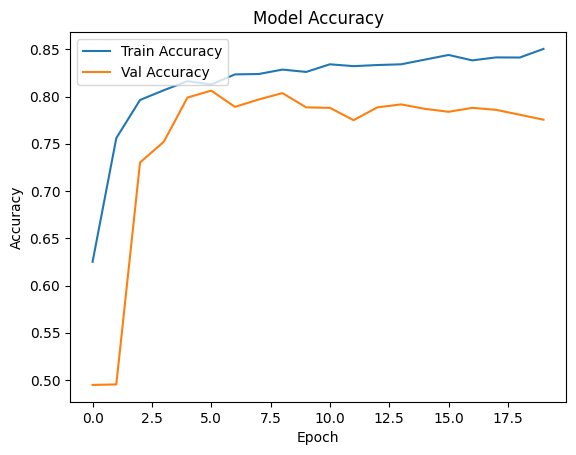

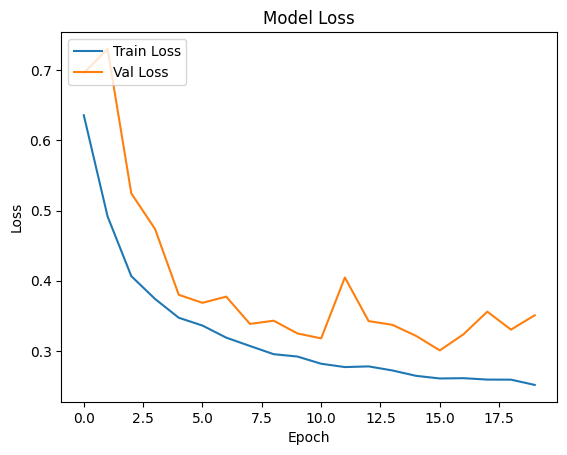

In [11]:
import matplotlib.pyplot as plt

# Affichage de la courbe de Aaccuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Affichage de la courbe de la perte
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


In [18]:
# Sauvegarder le modèle dans un fichier .h5
model = model.save('/kaggle/working/DPFAKE1_model.h5')